##Lab 1

Step 1 - Install Library

In [ ]:
# Install ANNOY
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551804 sha256=fe28c0a9a9246656c33a0282a08beb762a520eaf67336cc4c4d7a20d4c9c17ed
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


Step 2 - Import Library

In [ ]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import time

from annoy import AnnoyIndex

Step 3 - Create a Dummy Dataset

In [ ]:
# Build Random Dataset and Query Point
np.random.seed(42)
n_points = 1000
X = np.random.rand(n_points, 2) * 100  # random value at 100x100 space

# Query point (pick 1 random data point)
query = X[np.random.randint(0, n_points)]

Step 4 - Exact NN

In [ ]:
# Compute Exact NN Using Brute Force
# It will visit the data one by one
start = time.time()
distances = np.linalg.norm(X - query, axis=1)
idx_exact = np.argsort(distances)[:3]  # ambil 3 terdekat
time_exact = time.time() - start

print("Exact NN index:", idx_exact)
print("Exact NN jarak:", distances[idx_exact])
print("Waktu Exact:", round(time_exact*1000, 4), "ms")

Exact NN index: [219 898 593]
Exact NN jarak: [0.         1.36915938 2.27931544]
Waktu Exact: 11.1804 ms


Step 5 - Nearest Neighbors with ANNOY

In [ ]:
# ANNOY 3 Tree
f = 2  # dimensi
t = AnnoyIndex(f, 'euclidean')
for i, vec in enumerate(X):
    t.add_item(i, vec)

t.build(3)  # 3 trees

start = time.time()
idx_ann = t.get_nns_by_vector(query, 3)  # find 3 NN
time_ann = time.time() - start

print("\nAnnoy NN index:", idx_ann)
print("Annoy NN jarak:", [np.linalg.norm(X[i]-query) for i in idx_ann])
print("Waktu Annoy:", round(time_ann*1000, 4), "ms")


Annoy NN index: [219, 898, 770]
Annoy NN jarak: [np.float64(0.0), np.float64(1.369159376273702), np.float64(2.568167959732514)]
Waktu Annoy: 0.1202 ms


Step 6 - Visualize the NN Result

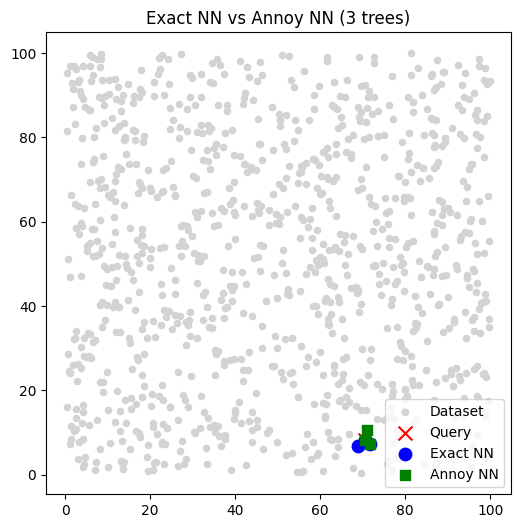

In [ ]:
# Visualize
# Knowing the NN produced by Exact NN and ANNOY
plt.figure(figsize=(6,6))
plt.scatter(X[:,0], X[:,1], c="lightgray", s=20, label="Dataset")
plt.scatter(query[0], query[1], c="red", marker="x", s=100, label="Query")

# Exact NN ditandai biru
plt.scatter(X[idx_exact,0], X[idx_exact,1], c="blue", s=80, label="Exact NN")

# Annoy NN ditandai hijau
plt.scatter(X[idx_ann,0], X[idx_ann,1], c="green", s=50, marker="s", label="Annoy NN")

plt.legend()
plt.title("Exact NN vs Annoy NN (3 trees)")
plt.show()

It can be seen that ANNOY does not select the exact same nearest neighbors as the exact NN method. However, the results are sufficiently accurate for similarity search tasks involving large datasets, offering a significant gain in computation speed.

## Lab 2

Step 1 - Install FAISS Library

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 39.1 MB/s eta 0:00:00


Step 2 - Import Libraries

In [ ]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

Step 3 - Create a Dummy Dataset

In [ ]:
# Build random data
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 data 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query point

Step 4 - Build Exact NN Model

In [ ]:
# Search NN using Exact NN
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

# Compute Exact NN Time
start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # Find 3 NN
end = time.time()
time_flat = end - start

Step 5 - Build FAISS Model

In [ ]:
# Compute FAISS
nlist = 10   # n-cluster (inverted list)
m = 2        # number of subvector
quantizer = faiss.IndexFlatL2(2)   # used by IVF for initiatl cluster
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

Step 6 - Compare The Performance

In [ ]:
# Print The Peformances
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.00020432472229003906
Waktu IVF+PQ: 0.0002675056457519531


Step 7 - Visualize

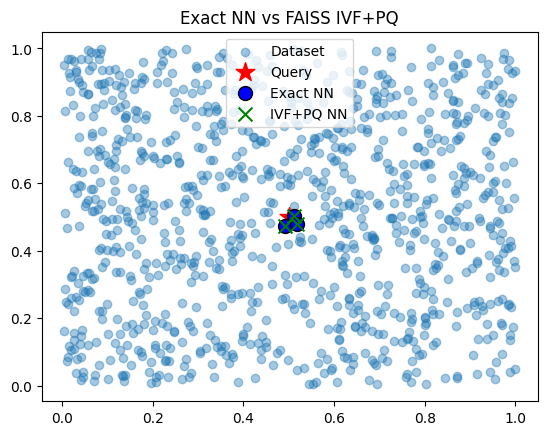

In [ ]:
# Visualize
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Flat NN -> Exact NN
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# IVF+PQ NN -> FAISS
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Exact NN vs FAISS IVF+PQ")
plt.show()

The result will be very similar NN either in exact NN or FAISS

## Lab 3

Step 1 - Install HNSW Library

In [ ]:
!pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp312-cp312-linux_x86_64.whl size=2528145 sha256=4124aa13895e121f9e52b47beec2d0630387117fe2b1813446b1af084f23b253
  Stored in directory: /root/.cache/pip/wheels/ac/39/b3/cbd7f9cbb76501d2d5fbc84956e70d0b94e788aac87bda465e
Successfully built hnswlib


Step 2 - Import Libraries

In [ ]:
import hnswlib
import numpy as np
import time
from sklearn.neighbors import NearestNeighbors

Step 3 - Create a Dummy Dataset

In [ ]:
# Build Dummy Dataset
num_elements = 1000
dim = 2
data = np.random.random((num_elements, dim)).astype(np.float32)

# Query point
query = np.array([[0.5, 0.5]], dtype=np.float32)
k = 5  # cari 5 tetangga terdekat

Step 3 - Build Exact NN Model

In [ ]:
# Build NN Model
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(data)

# Compute time performace
start = time.time()
distances, indices = nn.kneighbors(query)
end = time.time()

print("=== Exact NN ===")
print("Indices:", indices)
print("Distances:", distances)
print("Waktu:", end - start, "s")

=== Exact NN ===
Indices: [[830 247 473 913 592]]
Distances: [[0.00993625 0.01363944 0.01646171 0.03779694 0.03859071]]
Waktu: 0.005334377288818359 s


Step 4 - Build HNSW Model

In [ ]:
# Initiate Index
p = hnswlib.Index(space='l2', dim=dim)

# Define Max Elements
p.init_index(max_elements=num_elements, ef_construction=100, M=16)

# Add Data
p.add_items(data)

# Set searching parameter
p.set_ef(50)   # tradeoff speed vs accuracy

start = time.time()
labels, distances = p.knn_query(query, k=k)
end = time.time()

print("\n=== HNSW ===")
print("Indices:", labels)
print("Distances:", distances)
print("Waktu:", end - start, "s")


=== HNSW ===
Indices: [[830 247 473 913 592]]
Distances: [[9.8728990e-05 1.8603441e-04 2.7098786e-04 1.4286089e-03 1.4892431e-03]]
Waktu: 0.0002033710479736328 s


## Lab 4

Compare the 3 ANN method at the single time using large amout of data and features 1mio by 1mio.

In [ ]:
import numpy as np
import time
from annoy import AnnoyIndex
import faiss
import hnswlib

# ===============================
# Build 1mio rows with 5D
# ===============================
n_data = 1_000_000   # try 100_000 if you have limited memory
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# ===============================
# 2. Annoy
# ===============================
print("=== Annoy ===")
ann_index = AnnoyIndex(dim, 'euclidean')

start = time.time()
for i in range(n_data):
    ann_index.add_item(i, X[i])
ann_index.build(10)  # 10 trees
build_time = time.time() - start

start = time.time()
neighbors = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", neighbors[0][:5], "...")

# ===============================
# 3. FAISS (Flat Index)
# ===============================
print("\n=== FAISS (IndexFlatL2) ===")
faiss_index = faiss.IndexFlatL2(dim)

start = time.time()
faiss_index.add(X)
build_time = time.time() - start

start = time.time()
distances, indices = faiss_index.search(query, k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", indices[0][:5], "...")

# ===============================
# 4. HNSW (hnswlib)
# ===============================
print("\n=== HNSW (hnswlib) ===")
hnsw_index = hnswlib.Index(space='l2', dim=dim)

start = time.time()
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X)
build_time = time.time() - start

hnsw_index.set_ef(50)

start = time.time()
labels, distances = hnsw_index.knn_query(query, k=k)
query_time = time.time() - start

print("Build time:", build_time, "detik")
print("Query time:", query_time, "detik")
print("Neighbors:", labels[0][:5], "...")

=== Annoy ===
Build time: 23.35411524772644 detik
Query time: 0.00019407272338867188 detik
Neighbors: [473142, 815660, 216089, 418503, 261601] ...

=== FAISS (IndexFlatL2) ===
Build time: 0.015157461166381836 detik
Query time: 0.0058596134185791016 detik
Neighbors: [473142 815660 216089 418503 261601] ...

=== HNSW (hnswlib) ===
Build time: 182.22008776664734 detik
Query time: 0.00024247169494628906 detik
Neighbors: [473142 815660 216089 418503 261601] ...


All three ANN methods (Annoy, FAISS, and HNSW) produced identical nearest neighbors, showing consistent accuracy. FAISS had the fastest build time but slower queries, Annoy balanced build and query speed well, and HNSW took the longest to build but had the fastest queries, it is best for large-scale, real-time searches.

## Lab 5

ANN Performance by Recall Query Metric

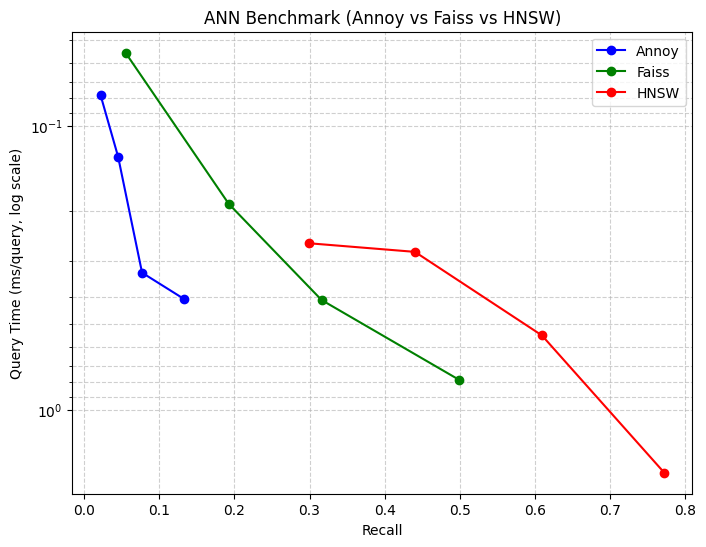

In [ ]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib
import matplotlib.pyplot as plt

# -------------------------------
# Dataset random
# -------------------------------
d = 128        # dimensi
nb = 100000    # jumlah database vector
nq = 1000      # jumlah query

np.random.seed(42)
xb = np.random.random((nb, d)).astype('float32')
xq = np.random.random((nq, d)).astype('float32')

# -------------------------------
# Ground truth dengan FAISS brute force
# -------------------------------
index_flat = faiss.IndexFlatL2(d)
index_flat.add(xb)
k = 10
_, gt_idx = index_flat.search(xq, k)

# -------------------------------
# Fungsi recall
# -------------------------------
def recall_at_k(I_pred, I_gt, k):
    correct = 0
    for i in range(len(I_pred)):
        correct += len(set(I_pred[i][:k]) & set(I_gt[i][:k]))
    return correct / (len(I_pred) * k)

# -------------------------------
# Benchmark Annoy
# -------------------------------
def run_annoy(xb, xq, n_trees=10, search_k=1000, k=10):
    f = xb.shape[1]
    index = AnnoyIndex(f, 'euclidean')
    for i, v in enumerate(xb):
        index.add_item(i, v)
    index.build(n_trees)

    start = time.time()
    I = [index.get_nns_by_vector(v, k, search_k=search_k) for v in xq]
    elapsed = (time.time() - start) * 1000 / len(xq)  # ms/query
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark FAISS IVF
# -------------------------------
def run_faiss(xb, xq, nlist=100, nprobe=10, k=10):
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    index.train(xb)
    index.add(xb)

    index.nprobe = nprobe
    start = time.time()
    _, I = index.search(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Benchmark HNSW
# -------------------------------
def run_hnsw(xb, xq, ef=100, M=16, k=10):
    num_elements = xb.shape[0]
    p = hnswlib.Index(space='l2', dim=d)
    p.init_index(max_elements=num_elements, ef_construction=200, M=M)
    p.add_items(xb)
    p.set_ef(ef)

    start = time.time()
    I, _ = p.knn_query(xq, k)
    elapsed = (time.time() - start) * 1000 / len(xq)
    rec = recall_at_k(I, gt_idx, k)
    return rec, elapsed

# -------------------------------
# Jalankan benchmark dengan beberapa parameter
# -------------------------------
results = {"Annoy": [], "Faiss": [], "HNSW": []}

# Annoy
for sk in [200, 500, 1000, 2000]:
    rec, t = run_annoy(xb, xq, n_trees=10, search_k=sk)
    results["Annoy"].append((rec, t))

# FAISS
for npb in [1, 5, 10, 20]:
    rec, t = run_faiss(xb, xq, nlist=100, nprobe=npb)
    results["Faiss"].append((rec, t))

# HNSW
for ef in [50, 100, 200, 400]:
    rec, t = run_hnsw(xb, xq, ef=ef)
    results["HNSW"].append((rec, t))

# -------------------------------
# Visualisasi trade-off
# -------------------------------
plt.figure(figsize=(8,6))
for label, color in zip(results.keys(), ["blue","green","red"]):
    recall, qtime = zip(*results[label])
    plt.plot(recall, qtime, marker="o", label=label, color=color)

plt.xlabel("Recall")
plt.ylabel("Query Time (ms/query, log scale)")
plt.yscale("log")
plt.gca().invert_yaxis()  # invert Y, makin kanan makin turun
plt.title("ANN Benchmark (Annoy vs Faiss vs HNSW)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

## Lab Assignment 1

In [ ]:
import numpy as np
import time
import faiss
from annoy import AnnoyIndex
import hnswlib

In [ ]:
# 1000/2D
n_data = 1000
dim = 2
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# === ANNOY ===
ann = AnnoyIndex(dim, 'euclidean')
start = time.time()
for i in range(n_data):
    ann.add_item(i, X[i])
ann.build(10)
ann.get_nns_by_vector(query[0], k, include_distances=True)
annoy_time = time.time() - start

# === FAISS ===
faiss_index = faiss.IndexFlatL2(dim)
start = time.time()
faiss_index.add(X)
faiss_index.search(query, k)
faiss_time = time.time() - start

# === HNSW ===
hnsw = hnswlib.Index(space='l2', dim=dim)
start = time.time()
hnsw.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw.add_items(X)
hnsw.set_ef(50)
hnsw.knn_query(query, k)
hnsw_time = time.time() - start

print(f"=== 1000 / 2D ===")
print("ANNOY:", annoy_time, "seconds")
print("FAISS:", faiss_time, "seconds")
print("HNSW:", hnsw_time, "seconds")

=== 1000 / 2D ===
ANNOY: 0.025025367736816406 seconds
FAISS: 0.00024580955505371094 seconds
HNSW: 0.04726529121398926 seconds


In [ ]:
# 1000/5D
n_data = 1000
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# === ANNOY ===
ann = AnnoyIndex(dim, 'euclidean')
start = time.time()
for i in range(n_data):
    ann.add_item(i, X[i])
ann.build(10)
ann.get_nns_by_vector(query[0], k, include_distances=True)
annoy_time = time.time() - start

# === FAISS ===
faiss_index = faiss.IndexFlatL2(dim)
start = time.time()
faiss_index.add(X)
faiss_index.search(query, k)
faiss_time = time.time() - start

# === HNSW ===
hnsw = hnswlib.Index(space='l2', dim=dim)
start = time.time()
hnsw.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw.add_items(X)
hnsw.set_ef(50)
hnsw.knn_query(query, k)
hnsw_time = time.time() - start

print(f"=== 1000 / 5D ===")
print("ANNOY:", annoy_time, "seconds")
print("FAISS:", faiss_time, "seconds")
print("HNSW:", hnsw_time, "seconds")

=== 1000 / 5D ===
ANNOY: 0.03307199478149414 seconds
FAISS: 0.0002751350402832031 seconds
HNSW: 0.10848307609558105 seconds


In [ ]:
# 1_000_000/2D
n_data = 1000000
dim = 2
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# === ANNOY ===
ann = AnnoyIndex(dim, 'euclidean')
start = time.time()
for i in range(n_data):
    ann.add_item(i, X[i])
ann.build(10)
ann.get_nns_by_vector(query[0], k, include_distances=True)
annoy_time = time.time() - start

# === FAISS ===
faiss_index = faiss.IndexFlatL2(dim)
start = time.time()
faiss_index.add(X)
faiss_index.search(query, k)
faiss_time = time.time() - start

# === HNSW ===
hnsw = hnswlib.Index(space='l2', dim=dim)
start = time.time()
hnsw.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw.add_items(X)
hnsw.set_ef(50)
hnsw.knn_query(query, k)
hnsw_time = time.time() - start

print(f"=== 1000000 / 2D ===")
print("ANNOY:", annoy_time, "seconds")
print("FAISS:", faiss_time, "seconds")
print("HNSW:", hnsw_time, "seconds")

=== 1000000 / 2D ===
ANNOY: 34.67384743690491 seconds
FAISS: 0.009383678436279297 seconds
HNSW: 118.11564493179321 seconds


In [ ]:
# 1_000_000/5D
n_data = 1000000
dim = 5
X = np.random.random((n_data, dim)).astype(np.float32)

# Query point
query = np.random.random((1, dim)).astype(np.float32)
k = 10

# === ANNOY ===
ann = AnnoyIndex(dim, 'euclidean')
start = time.time()
for i in range(n_data):
    ann.add_item(i, X[i])
ann.build(10)
ann.get_nns_by_vector(query[0], k, include_distances=True)
annoy_time = time.time() - start

# === FAISS ===
faiss_index = faiss.IndexFlatL2(dim)
start = time.time()
faiss_index.add(X)
faiss_index.search(query, k)
faiss_time = time.time() - start

# === HNSW ===
hnsw = hnswlib.Index(space='l2', dim=dim)
start = time.time()
hnsw.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw.add_items(X)
hnsw.set_ef(50)
hnsw.knn_query(query, k)
hnsw_time = time.time() - start

print(f"=== 1000000 / 5D ===")
print("ANNOY:", annoy_time, "seconds")
print("FAISS:", faiss_time, "seconds")
print("HNSW:", hnsw_time, "seconds")

=== 1000000 / 5D ===
ANNOY: 22.186280965805054 seconds
FAISS: 0.014441251754760742 seconds
HNSW: 213.77889037132263 seconds


In [ ]:
import pandas as pd

data = {
    "Criteria (Rows/Dimension)": ["1000/2D", "1000/5D", "1000000/2D", "1000000/5D"],
    "ANNOY (s)": [0.025025367736816406, 0.03307199478149414, 34.67384743690491, 22.186280965805054],
    "FAISS (s)": [0.00024580955505371094, 0.0002751350402832031, 0.009383678436279297, 0.014441251754760742],
    "HNSW (s)": [0.04726529121398926, 0.10848307609558105, 118.11564493179321, 213.77889037132263]
}

df = pd.DataFrame(data)
print(df)

  Criteria (Rows/Dimension)  ANNOY (s)  FAISS (s)    HNSW (s)
0                   1000/2D   0.025025   0.000246    0.047265
1                   1000/5D   0.033072   0.000275    0.108483
2                1000000/2D  34.673847   0.009384  118.115645
3                1000000/5D  22.186281   0.014441  213.778890


Based on the results, FAISS consistently achieved the fastest execution time across all dataset sizes and dimensions, showing high efficiency and scalability. ANNOY demonstrated moderate performance, with build time increasing as data size grew but still faster than HNSW for large datasets. Meanwhile, HNSW had the slowest build time, especially for higher dimensions, due to its complex graph-based structure. Overall, FAISS is the most suitable for large-scale applications, ANNOY offers a good balance between speed and accuracy, and HNSW is ideal when high query accuracy is prioritized over build speed.


## Lab Assignment 2

In [ ]:
import pandas as pd
import numpy as np
import time
import faiss
import hnswlib
from annoy import AnnoyIndex
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

In [ ]:
# Load dataset
df = pd.read_csv('songs_with_attributes_and_lyrics.csv')
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

X = df[features].values

# Standarisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10  # jumlah nearest neighbors

In [ ]:
n_data = X_scaled.shape[0]
dim = X_scaled.shape[1]

In [ ]:
# === Pilih query acak ===
query_idx = np.random.randint(0, n_data)
query = X_scaled[query_idx].reshape(1, -1)
print(f"Query track index: {query_idx}")

# === Exact NN (Brute Force) ===
nn = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
nn.fit(X_scaled)

start = time.time()
distances, indices = nn.kneighbors(query)
exact_time = time.time() - start

print("\n=== Exact NN ===")
print("Execution time:", round(exact_time, 4), "seconds")

# === ANNOY ===
ann_index = AnnoyIndex(dim, 'euclidean')
for i, vec in enumerate(X_scaled):
    ann_index.add_item(i, vec)
ann_index.build(10)  # 10 trees

start = time.time()
neighbors, distances_ann = ann_index.get_nns_by_vector(query[0], k, include_distances=True)
annoy_time = time.time() - start

print("\n=== ANNOY ===")
print("Execution time:", round(annoy_time, 4), "seconds")

# === FAISS (IndexFlatL2) ===
faiss_index = faiss.IndexFlatL2(dim)
faiss_index.add(X_scaled.astype('float32'))

start = time.time()
distances_faiss, indices_faiss = faiss_index.search(query.astype('float32'), k)
faiss_time = time.time() - start

print("\n=== FAISS ===")
print("Execution time:", round(faiss_time, 4), "seconds")

# === HNSWLIB ===
hnsw_index = hnswlib.Index(space='l2', dim=dim)
hnsw_index.init_index(max_elements=n_data, ef_construction=200, M=16)
hnsw_index.add_items(X_scaled.astype('float32'))
hnsw_index.set_ef(50)

start = time.time()
labels, distances_hnsw = hnsw_index.knn_query(query.astype('float32'), k=k)
hnsw_time = time.time() - start

print("\n=== HNSWLIB ===")
print("Execution time:", round(hnsw_time, 4), "seconds")


Query track index: 1913

=== Exact NN ===
Execution time: 0.0043 seconds

=== ANNOY ===
Execution time: 0.0003 seconds

=== FAISS ===
Execution time: 0.0028 seconds

=== HNSWLIB ===
Execution time: 0.0006 seconds


For query track 1913, Exact NN took about 0.0043 seconds since it checks all the data points to get the exact nearest neighbors. ANNOY and HNSWLIB were much faster because they use approximate methods to find neighbors, while FAISS was moderately fast with optimized exact search. Overall, the approximate methods are much faster while still giving almost the same results, and Exact NN is slower but accurate.